## Data processing
This script fetches and processes data from a user's anime list on MyAnimeList

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

# URL of the user's anime list on MyAnimeList
base_url = "https://myanimelist.net/animelist/juliaddd?"


# Sending an HTTP GET request to fetch the anime list page
response = requests.get(base_url)

# Checking if the request to the URL was successful 
if response.status_code == 200:
    # Parsing the HTML content of the page using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')


    element = soup.find('table', {'class': 'list-table'})
    # TODO: Refactor the code inside this if block
    if element:
        # Extracting JSON data from the data-items attribute
        json_anime_data = element.get('data-items')
        print('Successfully obtained data-items attribute')
        
        anime_list = []
        # Parsing the JSON data into a python list of dictionaries
        anime_data = json.loads(json_anime_data)
        
         # Iterating through each anime in the JSON data and extract relevant details for each anime
        for anime in anime_data:
            score = anime['score']
            title = anime['anime_title_eng']
            total_members = anime['anime_total_members']
            # total_scores = anime['anime_total_scores']
            score_val = anime['anime_score_val']
            popularity = anime['anime_popularity']
            genres = [genre['name'] for genre in anime['genres']]
            demographics = [demographic['name'] for demographic in anime['demographics']]
            
            
            # Appending the extracted details as a dictionary to the anime_list
            anime_list.append({
            # Users score for the anime (the target variable)
            'my_score': score,
            # English title of the anime
            'title': title,
            #idea: Edit the dictionary, remove total_members and total_score values
            # Total number of members who have this anime on their list
            'total_members': total_members,
            # Average score value of the anime
            'score_val': score_val,
            # Popularity ranking of the anime
            'popularity': popularity,
            # List of genres associated with the anime
            'genres': genres,
            # List of anime demographics - target audience age
            'demographics': demographics
            })
            
        
        
        df = pd.DataFrame(anime_list)
        print(df.head())

        df.to_csv('./data/anime_list.csv', index=False) 
    else:
        print('Element not found on the page')
else:
    print(f'Failed to retrieve page. Status code: {response.status_code}')

## Neural Network training
This script performs data preprocessing and trains a neural network to predict user scores for anime titles

In [13]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from gensim.models import Word2Vec
import numpy as np


df = pd.read_csv('./data/anime_list.csv')
# Loading the pre-trained Word2Vec model
word_vectors = Word2Vec.load('./models/anime_word2vec_model_updated')

# Handling missing values in the title column by replacing them with empty strings
df['title'] = df['title'].fillna('')

# Function to convert anime titles into vectors using the Word2Vec model
def title_to_vector(anime_title):
    # Getting the vector size from the model
    vector_size = word_vectors.vector_size
    # Initializing the vector with zeros
    vector = np.zeros(vector_size)
    # Split the title into individual words
    words = str(anime_title).split()
    word_count = 0
    for word in words:
        # Checking if the word exists in the Word2Vec vocabulary
        if word in word_vectors.wv:
            vector += word_vectors.wv[word]
            word_count += 1
    # Returning the average vector or a zero vector if no words found
    return vector / word_count if word_count > 0 else vector

df['title_vector'] = df['title'].apply(title_to_vector)

# Converting the title_vector column into separate columns for each vector component
title_vectors = pd.DataFrame(df['title_vector'].tolist(), index=df.index)
df = pd.concat([df, title_vectors], axis=1).drop(['title_vector', 'title'], axis=1)

# One-hot encoding the genres column
genres_encoder = OneHotEncoder(sparse_output=False)
genres_encoded = genres_encoder.fit_transform(df[['genres']])
genres_encoded_df = pd.DataFrame(genres_encoded, columns=genres_encoder.get_feature_names_out(['genres']))
df = pd.concat([df, genres_encoded_df], axis=1).drop('genres', axis=1)

# One-hot encoding the demographics column
demographics_encoder = OneHotEncoder(sparse_output=False)
demographics_encoded = demographics_encoder.fit_transform(df[['demographics']])
demographics_encoded_df = pd.DataFrame(demographics_encoded, columns=demographics_encoder.get_feature_names_out(['demographics']))
df = pd.concat([df, demographics_encoded_df], axis=1).drop('demographics', axis=1)

# Ensuring all column names are strings
df.columns = df.columns.astype(str)

# Normalizing numerical data using StandardScaler
scaler = StandardScaler()
numerical_columns = [col for col in df.columns if col not in ['my_score']]
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Defining the target variable Y and features X
Y = df['my_score']
X = df.drop(['my_score'], axis=1)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Defining the neural network model architecture
# Number of input features
input_shape = X_train.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
    # Apply dropout for regularization
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    # Output layer for regression
    tf.keras.layers.Dense(1)
])

# Compiling the model with optimizer, loss function, and evaluation metrics
model.compile(optimizer='adam',
              loss='mse',  # Mean Squared Error
              metrics=['mae'])  # Mean Absolute Error

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluating the model on the test data
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {mae}')

C:\Users\dobre\Documents\Code\Anime_Rating_Project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 29.3830 - mae: 4.7500 - val_loss: 20.3920 - val_mae: 3.4714
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 14.4595 - mae: 2.9165 - val_loss: 11.7279 - val_mae: 2.8722
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7101 - mae: 2.4098 - val_loss: 8.6952 - val_mae: 2.5768
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6406 - mae: 2.1328 - val_loss: 7.8121 - val_mae: 2.4092
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4045 - mae: 1.8532 - val_loss: 7.2232 - val_mae: 2.2870
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.8793 - mae: 1.6119 - val_loss: 6.8364 - val_mae: 2.1778
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7364 - mae: 1.5485 - val_loss: 7.0812 - val_mae: 2.1793
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.9962 - mae: 1.3647 - val_loss: 7.2354 - val_mae: 2.1587
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5295 - mae: 1.275

## Visualizing
This script uses matplotlib to visualize the training history of a neural network model, focusing on loss and Mean Absolute Error (MAE) metrics

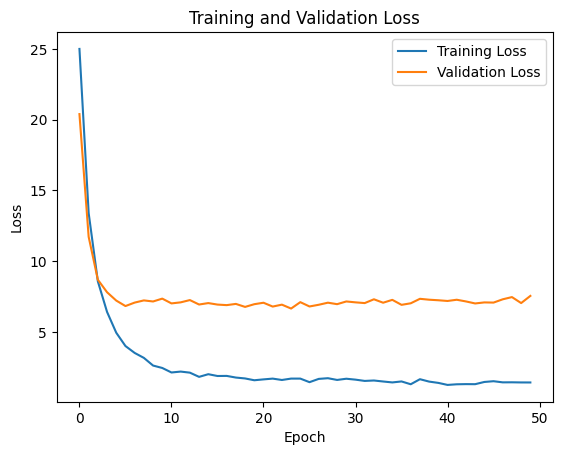

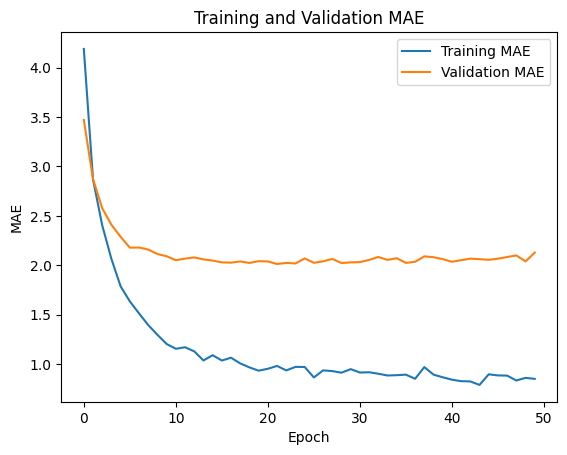

In [14]:
import matplotlib.pyplot as plt

# Getting the loss and metric values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plotting the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation MAE over epochs
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()